In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns

/home/osvaldo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Modelos Multiparamétricos y Modelado jerárquico

En los capítulos previos aprendimos sobre los conceptos centrales de la estadística Bayesiana. En este capítulo veremos como crear y analizar modelos con más de un parámetro y estudiaremos como generar modelos jerárquicos, es decir modelos donde unos parámetros dependen de otros de forma jerárquica.

## Modelos Multiparamétricos

Prácticamente todos los modelos de interés en estadística, son multiparamétricos, es decir modelos con más de un parámetro. 

Suele suceder que no todos los parámetros requeridos para construir un modelo son de interés, supongamos que quisiéramos estimar el valor medio de una distribución Gaussiana, a menos que sepamos el valor _real_ de la desviación estándar, nuestro modelo deberá contener un parámetro para la media y uno para la desviación estándar. Los parámetros que no son de inmediato interés pero son necesarios para construir nuestros modelos se llaman _nuisance parameters_ (o parámetro estorbo).

Recordemos que en estadística Bayesiana todos los parámetros tienen el mismo estatus, por lo que la diferencia entre _nuisance_ o no _nuisance_ no es fundamental bajo ningún concepto, si no que depende completamente de nuestras preguntas.

En principio podría parecer que incorporar parámetros que no nos interesan es un ejercicio de futilidad. Sin embargo, es todo lo contrario, al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propaguen de forma adecuada a los resultados.

En términos generales un modelo con dos parámetros será algo como:

$$P(\theta_1, \theta_2|y) \propto P(y|\theta_1, \theta_2) P(\theta_1, \theta_2)$$

lo que facilmente se puede generalizar a un modelo de más de dos parámetros. La principal diferencia con lo que ya habíamos visto es que ahora el _a posteriori_ será bidimensional (asumiendo que $\theta_1$, $\theta_2$ son escalares y no vectores).

Supongamos por un momento que $\theta_2$ no nos interesa realmente ¿Como hacemos entonces para expresar el _a posteriori_ solo en términos de $\theta_1$? Lo que debemos hacer es obtener la distribución marginal del _a posteriori_ respecto del parámetro de interés. Matemáticamente esto es:

$$P(\theta_1|y) = \int P(\theta_1, \theta_2|y) d\theta_2$$

Es decir integramos el _a posteriori_ sobre todos los valores posibles de los parámetros que no nos interesan. Para el caso de variables discretas la integral se convierte en una suma.

En la siguiente figura se puede observar tres distribuciones. La distribución conjunta de $\theta_1$ y $\theta_2$ (_joint distribution_) en el centro. Y las distribuciones marginales de $\theta_1$ en el _margen_ superior y de $\theta_2$ en el _margen_ derecho.

/home/osvaldo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


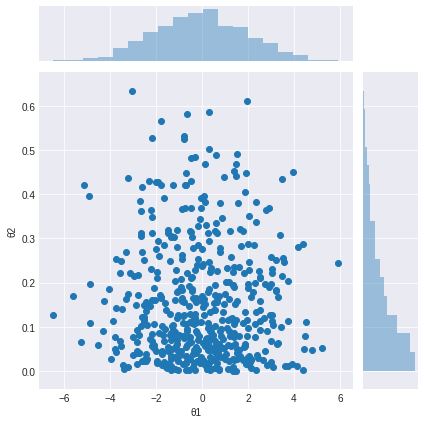

In [2]:
np.random.seed(123)
x = np.random.normal(0, 2, 500)
y = np.random.beta(1, 5, 500)
x_name, y_name = 'θ1', 'θ2'  
data = pd.DataFrame(data=np.array([x, y]).T, columns=[x_name, y_name])
sns.jointplot(x=x_name, y=y_name, data=data, stat_func=None);

Como veremos a continuación al usar PyMC3 no necesitamos marginalizar _manualmente_ los parámetros ya que el _a posteriori_ lo obtenemos como un _array_ que puede ser indexado para obtener la distribución marginal de cual parámetro de interés.

Resumiendo cuando escuchemos que se habla sobre la distribución marginal de $x$,  simplemente se está diciendo que es la distribución de $x$ promediado sobre el resto de los parámetros.

El marginalizar variables no solo sirve para obtener _rebanadas_ del _a posteriori_, puede ser una herramienta útil para simplificar el tratamiento matemático y/o computacional de un problema, veremos un ejemplo de esto en el capítulo 9 cuando hablemos sobre modelos de mezcla.

###  Inferencias lumínicas

En 1882 Simon Newcomb realizó un experimento a fin de determinar la velocidad de la luz (en realidad realizó varios a lo largo de varios años). Newcomb midió el tiempo que le tomaba a la luz recorrer 7,4437 kilómetros. 

A continuación se muestra sus resultados, 66 mediciones expresadas en $1\times10^{-2}$ segundos.

In [3]:
datos = np.array([24828, 24826, 24833, 24824, 24834, 24756, 24827, 
                  24816, 24840, 24798, 24829, 24822, 24824, 24821, 
                  24825, 24830, 24823, 24829, 24831, 24819, 24824, 
                  24820, 24836, 24832, 24836, 24828, 24825, 24821, 
                  24828, 24829, 24837, 24825, 24828, 24826, 24830, 
                  24832, 24836, 24826, 24830, 24822, 24836, 24823, 
                  24827, 24827, 24828, 24827, 24831, 24827, 24826, 
                  24833, 24826, 24832, 24832, 24824, 24839, 24828, 
                  24824, 24825, 24832, 24825, 24829, 24827, 24828, 
                  24829, 24816, 24823])



Si graficamos estas medidas veremos que la distribución parece Gaussiana excepto por dos medidas inusualmente bajas.

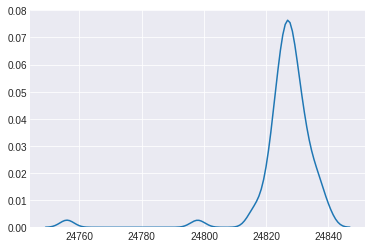

In [4]:
sns.kdeplot(datos);

Por simplicidad vamos a suponer que los datos siguen una distribución Gaussiana, después de todo es lo que en general se esperaría al medir una misma _cosa_ varias veces. Una distribución Gaussiana queda definida por dos parámetros, la media y la desviación estándar, como desconocemos estas dos cantidades necesitamos establecer dos _a prioris_ uno para cada parámetro. Un modelo probabilístico razonable sería el siguiente.

$$\mu \sim U(l, h)$$
$$\sigma \sim \text{Half-Normal}(\sigma_{\sigma})$$
$$y \sim \mathcal{N}(\mu, \sigma)$$

Es decir, $\mu$ proviene de una distribución uniforme entre los límites $l$ y $h$ y $\sigma$ proviene de una media-normal (_half-normal_) con desviación estándar $\sigma_{\sigma}$, esta distribución es como una Gaussiana pero restringida rango $[0, \infty]$. Por último los datos $y$, como dijimos anteriormente, proviene de una distribución normal, especificada por $\mu$ y $\sigma$.

Usando los diagramas de Kruschke:

<img src="imagenes/velocidad_luz_g.png" width=300>

Si desconocemos por completo cuales podrían ser los valores de $\mu$ y de $\sigma$, podemos fijar valores para los _a prioris_ que reflejen nuestra ignorancia. Por ejemplo para $\mu$ forma general de hacer esto es usando los datos por ejemplo podés decir que la media es una distri

Para la distribución uniforme una opción podría ser fijar $(l=0, h=1\times10^9)$, es decir asumimos que el tiempo que le demora a la luz recorrer los 7442 metros del experimento va entre 0 y 1 segundo (el límite inferior de 0 tiene sentido ya que las velocidades no pueden ser negativas, el límite superior de un 1 segundo es un valor elevado en la escala de los datos). Una alternativa podría ser $(l=24000, h=25000)$, que es un rango bastante más amplio que el de los datos.

Otra posibilidad sería usar los datos como guía por ejemplo $(l=datos.min() / 100, h=l=datos.min() * 100)$. De esta forma garantizamos que el _a priori_ contenga el rango de los datos pero que sea mucho más amplio, reflejando que no tenemos demasiado información para fijar un _a priori_ de forma más precisa. 

En la siguiente celda podrán ver que he elegido un par de _a prioris_ y hay otros comentados. Comparen como corre el modelo con los distintos _a prioris_ tanto en términos de los resultados como los tiempos y _calidad_ del muestreo.

In [5]:
with pm.Model() as modelo_g:
    # los a prioris
    μ = pm.Uniform('μ', 24000, 25000)
    #μ = pm.Uniform('μ', 0, 1E9) # un a priori alternativo
    #μ = pm.Normal('μ', 24500, 100) otro a priori alternativo
    σ = pm.HalfNormal('σ', sd=25)
    #σ = pm.HalfNormal('σ', sd=datos.std() * 100)
    # el likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=datos)
    trace_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, μ_interval__]
100%|██████████| 1500/1500 [00:01<00:00, 1177.53it/s]
The acceptance probability does not match the target. It is 0.8786161780250733, but should be close to 0.8. Try to increase the number of tuning steps.


El traceplot luce bien por lo que podemos continuar con el análisis pero ustedes podrían querer hacer algunas de las pruebas diagnósticas que vimos en el capítulo anterior (solo para estar seguros).

Como se puede ver el traceplot tiene ahora dos filas, una por cada parámetro. Cada una de estas filas corresponde a una variable _marginal_ del _a posteriori_ que en este caso es bi-dimensional.

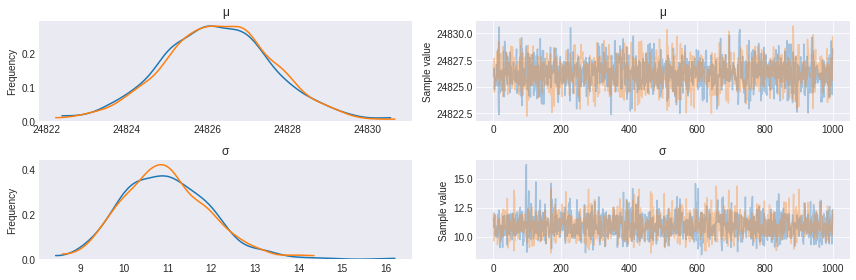

In [6]:
pm.traceplot(trace_g);

Vamos a llamar a `summary` y luego usaremos estos valores para compararlos con los de otro modelo.

In [7]:
pm.summary(trace_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,24826.236354,1.357651,0.029575,24823.556052,24828.937552,1850.135050,0.999902
σ,10.966881,1.000175,0.021269,9.034281,12.862541,2009.926449,0.999500


A continuación podemos observar la distribución _a posteriori_ (que como ya mencionamos en bidimensional)

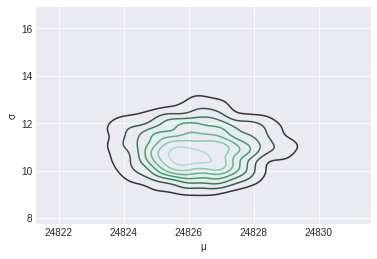

In [8]:
sns.kdeplot(trace_g['μ'], trace_g['σ'])
plt.xlabel('μ')
plt.ylabel('σ');

Una vez computado el _a posteriori_ podemos realizar diversos cálculos a partir de el. Uno de esos cálculos consiste en _simular datos_ ($\tilde{y}$). Matemáticamente lo que queremos calcular es:

$$p(\boldsymbol{\tilde{y}} \,|\, \boldsymbol{y}) = \int p(\boldsymbol{\tilde{y}} \,|\, \theta) \, p(\theta \,|\, \boldsymbol{y}) \, d\theta$$

donde:

$\boldsymbol{y}$ son los datos observados mientras que $\theta$ corresponde a los parámetros del modelo. 

Siguiendo el ejemplo de la velocidad de la luz $\theta$ corresponde a $\mu$ y a $\sigma$ y computacionalmente podemos obtener $\boldsymbol{\tilde{y}}$ de la siguiente forma:

1. Elegimos al azar un índice del `trace` generado por PyMC3 (un valor para $\mu_i$ y $\sigma_i$)
2. Generamos un _dato sintético_ $\tilde{y_i}  \sim N(\mu_i, \sigma_i)$
3. Repetimos 1 y 2 cuantas veces necesitemos.

Usando PyMC3 es muy fácil generar datos a partir del _a posteriori_. El siguiente código devuelve 100 predicciones cada una de ellas de tamaño igual al de los datos (esto es importante para que la comparación sea _justa_).

In [9]:
ppc = pm.sample_ppc(trace_g, 100, modelo_g, size=len(datos))

100%|██████████| 100/100 [00:00<00:00, 2128.54it/s]


Los datos simulados los podemos usar para compararlos con los datos observados y de esta forma evaluar el modelo. Esto se conoce como prueba predictivas _a posteriori_ y ya adelantamos algo en el capítulo 1. En la siguiente gráfica la linea azul corresponde a los datos observados mientras que las lineas magentas (semitrasparentes) corresponden a datos predichos por el modelo.

(0, 24840)

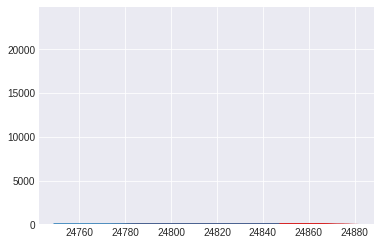

In [10]:
for ỹ in ppc['y']:
    sns.kdeplot(ỹ, color='C3', alpha=0.1)
sns.kdeplot(datos);
plt.ylim(0, datos.max())

Según la gráfica anterior, ¿Cuán bueno considerás que es nuestro modelo?

###  Modelos robustos

Un problema con el modelo anterior es que asume una distribución normal pero tenemos dos puntos que caen muy alejados de los valores medios. Esos puntos podrían estar alejados debido a errores experimentales en la toma de esos dos datos o podría haber un error al registrar los o al trascribirlos. Si algo de esto sucedió podríamos justificar su eliminación de nuestro conjunto de datos (dejando registro de la eliminación y de las razones por las cuales lo hicimos). Otra opción es usar el rango inter-cuartil (u otro método _estadístico_) para declarar esos dos puntos como datos aberrantes y desterrarlos de nuestros datos! Otra opción es dejarlos pero utilizar un modelo más robusto a valores alejados de la media. 

Uno de los inconvenientes al asumir normalidad, es que la media es muy sensible a valores aberrantes. La razón está en la colas de la Gaussiana, aún cuando las colas se extienden de $-\infty$ a $\infty$, la probabilidad de encontrar un valor cae rápidamente a medida que nos alejamos de la media, como se puede apreciar en la siguiente tabla que indica el porcentaje de valores que se encuentra a medida que nos alejamos de la media en unidades de desviación estándar (sd).

| sd |  % |
|:-:|:-:|
| 1 |  68 |
| 2 | 95  |
| 3 | 99.7 |
| 4 | 99.994 |
| 5 | 99.99994 |

Una alternativa a la distribución Gaussiana es usar una distribución t de Student, lo interesante de esta distribución es que además de estar definida por una media y una escala (análogo de la desviación estándar) está definida por un parámetro usualmente llamado $\nu$. Por su uso en estadística frecuentista $\nu$ se llama grados de libertad pero para el uso que se le suele dar en estadística Bayesiana tiene más sentido seguir la recomendación de Kruschke y llamarle parámetro de _normalidad_, ya que $\nu$ controla cuan _gordas_ son las colas de la distribución. Cuando $\nu = 1$ (la distribución se llama de Cauchy o de Lorentz) las colas son muy gordas, el 95% de los puntos está entre -12,7 y 12,7, en cambio en una Gaussiana (con desviación estándar 1) esto ocurre entre -1,96 y 1,96. En el límite de $\nu$ tendiendo a infinito estamos en presencia de una Gaussiana. La distribución t es realmente particular, cuando $\nu <= 1$ la distribución no tiene media definida y la varianza solo está definida para valores de $\nu > 2$.

La siguiente figura muestra una distribución t de Student para distintos valores de $\nu$.

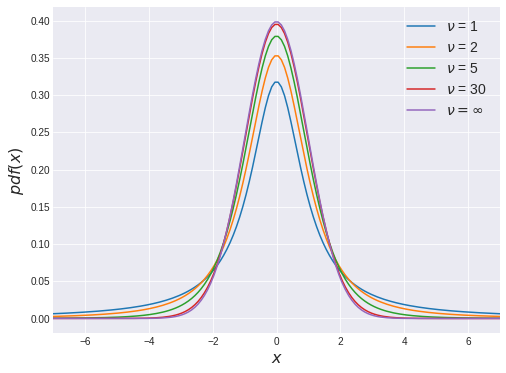

In [11]:
plt.figure(figsize=(8, 6))

x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', rotation=90, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);

Ahora que conocemos la distribución t de Student, podemos usarla en nuestro modelo:

$$\mu \sim U(l, h)$$
$$\sigma \sim \mathcal{HN}(\sigma_h)$$
$$\nu \sim Expon(\lambda)$$
$$y \sim \mathcal{t}(\mu, \sigma, \nu)$$

En algunos modelos puede ser buena idea sumar 1 a la distribución exponencial a fin de asegurarse que $\nu \ge 1$ . En principio $\nu$ puede tomar valores de [0, $\infty]$, pero en mi experiencia valores de $\nu < 1$ pueden traer problemas durante el muestreo, ya que pueden aparecer valores demasiado alejados de la media (las colas son extremadamente gordas!). Esto puede ocurrir con modelos con datos _marcadamente aberrantes_, veremos un ejemplo de esto en el capítulo 4.

Gráficamente:

<img src="imagenes/velocidad_luz_t.png" width=400>

In [12]:
with pm.Model() as modelo_t:
    # los a prioris
    μ = pm.Uniform('μ', 24000, 25000)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    # el likelihood
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=datos)
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_log__, σ_log__, μ_interval__]
100%|██████████| 2500/2500 [00:03<00:00, 716.41it/s]


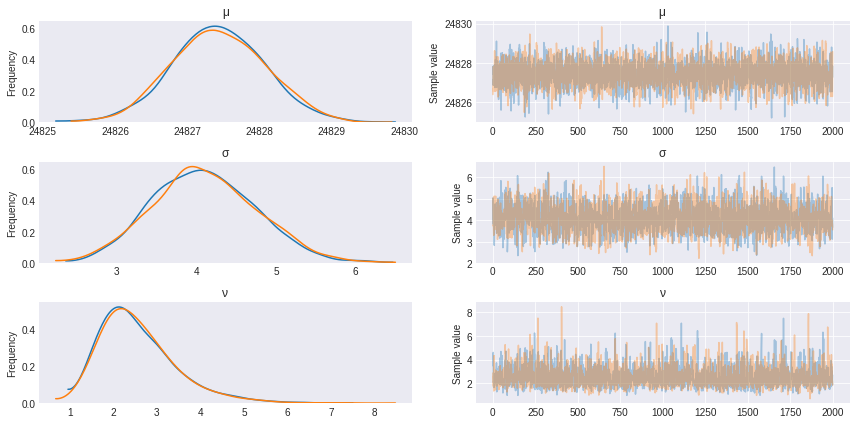

In [13]:
pm.traceplot(trace_t);

In [14]:
pm.summary(trace_t).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,24827.42,0.64,0.01,24826.20,24828.70,3796.69,1.0
σ,4.09,0.65,0.01,2.83,5.31,2358.75,1.0
ν,2.56,0.89,0.02,1.23,4.45,2284.00,1.0


En este caso, vemos que la estimación de $\mu$ es muy similar entre los dos modelos, aunque la estimación de $\sigma$, pasó de ser de ~10 a ~4. Esto es consecuencia de que la distribución t asigna menos peso a los valores alejados de la media que la distribución Gaussiana.

Nota: Según mediciones más modernas $\mu$ debería andar alrededor de ~22315, bastante alejado de las medidas realizadas por Newcomb en este experimento (otros experimentos realizados por el dieron valores más cercanos a las medidas actuales).

In [15]:
#sns.kdeplot(trace_t['mu'], trace_t['sigma']);

Hagamos un prueba predictiva _a posteriori_ para el nuevo modelo.

In [16]:
ppc = pm.sample_ppc(trace_t, 100, modelo_t, size=len(datos))

100%|██████████| 100/100 [00:00<00:00, 2726.26it/s]


(24700, 25000)

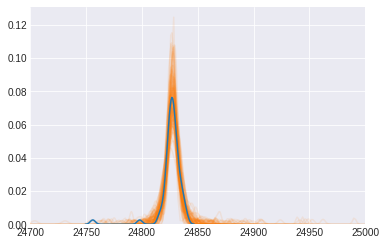

In [17]:
for ỹ in ppc['y']:
    sns.kdeplot(ỹ, color='C1', alpha=0.1)
sns.kdeplot(datos)
plt.xlim(24700, 25000)

¿Qué conclusión se puede sacar de comparar esta ppc con la anterior?

### Accidentes mineros

Este ejemplo está tomado del [tutorial](http://pymc-devs.github.io/pymc3/getting_started/#case-study-2-coal-mining-disasters) de PyMC3. 

El problema es el siguiente tenemos un registro del número de accidentes en minas de carbón ubicadas en el Reino Unido que ocurrieron entre 1851 y 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)). Se sospecha que la aplicación de ciertas regulaciones de seguridad tuvo como efecto una disminución en la cantidad de catástrofes. Por lo tanto nos interesa averiguar el año en que la tasa cambió y nos interesa estimar ambas tasas. 

Los datos son los siguientes, por un lado tenemos la variable _catástrofes_ que contiene la cantidad de accidentes por año y por el otro la variable _años_ conteniendo el rango de años para los cuales tenemos datos. Si prestan atención verán que _catástrofes_ es un arreglo enmascarado (o _masked array_). Esto es un tipo especial de arreglo de NumPy donde cada elemento del arreglo contiene asociado un valor _True_ o _False_ el cual indica si el elemento debe o no ser usado durante cualquier tipo de operación. En este caso como faltan datos para dos años lo que se ha hecho es marcar esa falta de datos con un valor centinela de -999, esta es la forma de indicarle a PyMC3 la presencia de datos faltantes, alternativamente se pueden pasar los datos como un _dataframe_ de Pandas conteniendo el valor especial `NAN` (que es el valor por defecto en Pandas para lidiar con datos faltantes).

Bien, pero para que molestarse con datos faltantes si en general es más fácil eliminarlos. una de las razones es que esto puede conducir a pérdida de información cuando por cada observación tenemos más de una variable o cantidad de interés. Por ejemplo si tenemos 50 sujetos a los que les hemos medido la presión, la temperatura y el ritmo cardíaco, pero sucede que para 4 de ellos no contamos con el datos de la presión (por que alguien se olvidó de medirlo o registrarlo, o por que el tensiómetro se rompió, o por lo que sea). Podemos eliminar esos cuatro sujetos del análisis y perder por lo tanto información sobre la presión y ritmo cardíaco, o podemos usar todos los datos disponibles y además estimar los valores de temperatura faltantes. En el contexto de la estadística Bayesiana los datos faltantes se tratan como un parámetro desconocido del modelo que puede ser estimado.

In [18]:
datos = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                             3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                             2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                             1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                             0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                             3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                             0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
años = np.arange(1851, 1962)

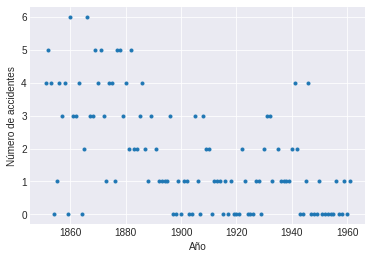

In [19]:
plt.plot(años, datos, '.')
plt.ylabel("Número de accidentes")
plt.xlabel("Año");

Para modelar los accidentes usaremos una distribución de Poisson. Como creemos que la cantidad media de accidentes es distinta antes y después de la introducción de regulaciones de seguridad usaremos dos valores de tasas medias de accidentes ($t_0$ y $t_1$). Además deberemos estimar un punto de corte ($pc$) que dividirá los años para los cuales se aplica la tasa de accidentes $t_0$ de los cuales se aplica la tasa $t_1$:

$$A_t \sim Poisson(tasa)$$

$$tasa = \begin{cases}
t_0, \text{si } t \ge pc,\\
t_1, \text{si } t \lt pc
\end{cases}$$

Los _a prioris_ que usaremos serán:

$$t_0 \sim Expon(1)$$
$$t_1 \sim Expon(1)$$
$$pc \sim U(A_0, A_1)$$

Donde la distribucion uniforme es discreta y $A_0$ y $A_1$ corresponden al primer y último año considerado en el análisis respectivamente 


Gráficamente el modelo es:



Una peculiaridad de la implementación de este modelo en PyMC3 es el uso de la función `pm.switch` (linea 10). Esta es en realidad una función de Theano y equivale a un _if else_ de Python. Si el primer argumento es _True_ entonces devuelve el segundo argumento caso contrario el tercer argumento. Como resultado tenemos que _tasa_ es un vector de longitud igual a la de _años_ y cuyos elementos corresponden a una repetición $t_0$ seguida de una repetición $t_1$, la cantidad exacta de repeticiones de $t_0$ y $t_1$ está controlada por la condición $pc \ge$ _años_. De esta podemos al muestrear $pc$ modificamos que años reciben cual tasa para el cálculo del _likelihood_.

In [20]:
# tasa = []
# for año in años:
#     if pc >= años:
#         tasa.append(t_0)
#     else:
#         tasa.append(t_1)

In [21]:
with pm.Model() as modelo_cat:

    pc = pm.DiscreteUniform('pc', lower=años.min(), upper=años.max(), testval=1900)

    # Priors para las tasas antes y después del cambio.
    t_0 = pm.Exponential('t_0', 1)
    t_1 = pm.Exponential('t_1', 1)

    # Asignamos las tasas a los años de acuerdo a pc
    tasa = pm.math.switch(pc >= años, t_0, t_1)

    disasters = pm.Poisson('disasters', tasa, observed=datos)
    trace_cat = pm.sample(4500)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [pc]
>NUTS: [t_1_log__, t_0_log__]
100%|██████████| 5000/5000 [00:04<00:00, 1133.77it/s]
The number of effective samples is smaller than 10% for some parameters.


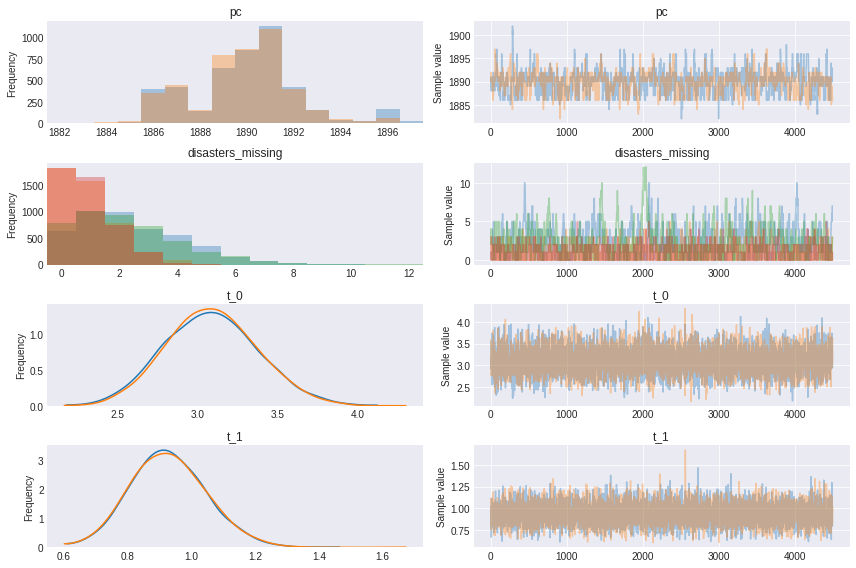

In [22]:
pm.traceplot(trace_cat);

In [23]:
pm.summary(trace_cat).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pc,1889.89,2.29,0.09,1886.00,1894.00,543.30,1.0
disasters_missing__0,2.37,1.94,0.11,0.00,6.00,298.40,1.0
disasters_missing__1,0.92,0.97,0.03,0.00,3.00,918.13,1.0
t_0,3.09,0.29,0.00,2.51,3.63,5044.35,1.0
t_1,0.93,0.12,0.00,0.71,1.16,5945.27,1.0


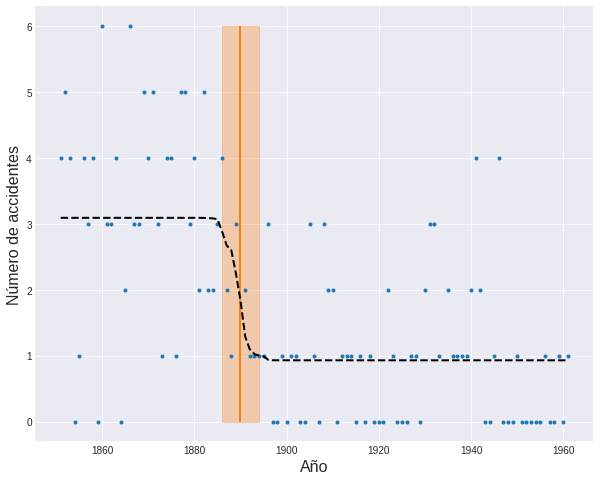

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(años, datos, '.')
plt.ylabel("Número de accidentes", fontsize=16)
plt.xlabel("Año", fontsize=16)

plt.vlines(trace_cat['pc'].mean(), datos.min(), datos.max(), color='C1', lw=2)
accidentes_promedio = np.zeros_like(datos, dtype='float')
for i, año in enumerate(años):
    idx = año < trace_cat['pc']
    accidentes_promedio[i] = ((trace_cat['t_0'][idx].sum() + trace_cat['t_1'][~idx].sum()) 
                              / (len(trace_cat) * trace_cat.nchains))

pc_hpd = pm.hpd(trace_cat['pc'])
plt.fill_betweenx([datos.min(), datos.max()], pc_hpd[0], pc_hpd[1], alpha=0.3, color='C1');
plt.plot(años, accidentes_promedio,  'k--', lw=2);

## Modelos Jerárquicos

El siguiente ejemplo está tomado del capítulo 9 del libro "Doing Bayesian Data Analysis de John K. Kruschke". Supongamos que en vez de 1 moneda tenemos 3, supongamos además que sabemos que las tres monedas fueron echas con la misma matriz (en la misma fábrica). Para estimar el valor de $\theta$ tenemos dos opciones:

1) estimar un valor de $\theta$ para cada moneda por separado.

2) juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

La ventaja de la opción 1 es que las monedas podrían diferir entre si por lo que calcular 3 valores de  $\theta$ podría ser muy informativo. La desventaja de este modelo es que hace caso omiso a la información que indica que las 3 monedas tienen un origen común, por lo que es probable que compartan características.

La ventaja de la opción 2 es que la cantidad de datos por parámetro aumentó, lo que reduce la incerteza. El problema es que pasamos a asumir que las 3 monedas son en realidad una, lo cual no sería problemático si las tres monedas fueran muy similares entre si, pero esto podría no ser una buena aproximación.

Una tercera opción es hacer algo a mitad de camino entre 1 y 2. Esto se consigue construyendo un modelo jerárquico o modelo multinivel. Este tipo de modelo nos permitirá estimar un valor de $\theta$ para cada moneda de forma tal que la estimación de cada valor de $\theta$ influencie al resto.

En estadística Bayesiana construir modelos jerárquicos es sencillo. A continuación veremos que un modelo jerárquico para las 3 monedas es muy similar al usado para el caso de 1 sola moneda solo que ahora colocamos un _a priori_ sobre el _a priori_!

Recordemos, el modelo del capítulo anterior era:

$$\theta \sim \operatorname{Beta}(\alpha, \beta)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

En un modelo jerárquico los argumentos de la distribución Beta ($\alpha$ y $\beta$) no son constantes si no que son valores que proviene de alguna otra distribución. En nuestro tendremos que:

$$ \mu \sim \operatorname{Beta}(\alpha, \beta)$$
$$ \kappa = \operatorname{Gamma}(s, r)$$

$$\theta \sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

Gráficamente, tenemos:

<img src="imagenes/modelo_3_monedas_jerarquico.png" width=250>

En los modelos jerárquicos a $\mu$ y a $\kappa$ se llama _hiper a prioris_ o _hiperparámetros_ ya que son ellos quienes determinan el valor del _a priori_. La diferencia entre el modelo del capítulo anterior y el del presente es que ahora los valores que puede tomar $\theta$ dependen no ya de una distribución fija($\alpha=1$ y $\beta=1$) si no de una distribución que depende de los valores de $\mu$ y $\kappa$, y que estimaremos a partir de los datos. Es decir es posible estimar el _a priori_ a partir de los datos, pero solo por que hemos introducido _hiper a prioris_. 

Recordarán que la distribución Beta se podía parametrizar en términos de $\alpha$ y $\beta$, pero también de $\mu$  y $\kappa$, donde $\mu$ es la media y $\kappa$ es la concentración (la inversa de la dispersión). Tenemos entonces que $\mu$ reflejará el valor promedio de 3 valores de $\theta$ y que si la proporción de caras en las tres monedas es similar entre si $\kappa$ tomara un valor más alto, mientras que si las monedas son diferentes entre si $\kappa$ tomará un valor más bajo.

### ¿Por qué la elección de los hiper _a prioris_?

Bueno dado que $\mu$ es la media del vector $\theta$ (y que $\theta$ solo puede tomar valores entre 0 y 1), $\mu$ queda restringida a valores entre 0 y 1 (al igual que una distribución beta), siguiendo el mismo razonamiento $\kappa$ va entre $[0, \infty]$ al igual que la distribución gamma. Otras distribuciones igualmente razonables podrían haber sido:

* $ \mu \sim U(0, 1)$
* $ \kappa \sim \mathcal{HN}(\sigma=100)$


Primero que nada generemos algunos datos sintéticos y los pondremos de una forma que sea más simple pasárselos al modelo, esto quedará un poco más claro al la especificación del modelo.

Vamos a suponer que con cada una de las 3 monedas hicimos 10 experimentos de Bernoulli (las arrojamos al aire) y obtuvimos como resultado, para cada caso, 5 caras.

In [26]:
N =  [10, 10, 10]  # Número de experimentos por moneda
z =  [5, 5, 5]  # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# lista con 1 para caras y 0 para cecas
datos = []  
for i, experimentos in enumerate(N):
    datos.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

Como no sabemos demasiado sobre $\mu$ y $\kappa$, vamos a elegir $ \mu \sim \operatorname{Beta}(\alpha=2, \beta=2)$, lo que equivale a una distribución centrada en 0.5, pero que casi asigna la misma probabilidad a todos los valores entre 0 y 1. Y $ \kappa = \operatorname{Gamma}(s=1, r=0.1)$, lo que equivale a una curva con media y  desviación estándar 10.

La especificación del modelo es igual a lo que hemos venido haciendo la única diferencia es que en la linea 7 podemos observar que hay una argumento llamando _shape_. Esto nos permite especificar las dimensiones de (en este caso) _theta_. PyMC3 permite escribir modelos _vectorizados_ ahorrándonos el tener que escribir _for loops_. Esa es la razón por la cual en la celda superior creamos un vector _monedas_ que usamos en la linea 9 (de la especificación del modelo) para indexar _theta_.

In [27]:
with pm.Model() as modelo_j:
    # definimos los hiperparámetros
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=1, beta=0.1)
    #κ = pm.Gamma('κ', mu=10, sd=10)
    
    # definimos el a priori
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    trace_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ_logodds__, κ_log__, μ_logodds__]
100%|██████████| 2500/2500 [00:03<00:00, 772.50it/s]


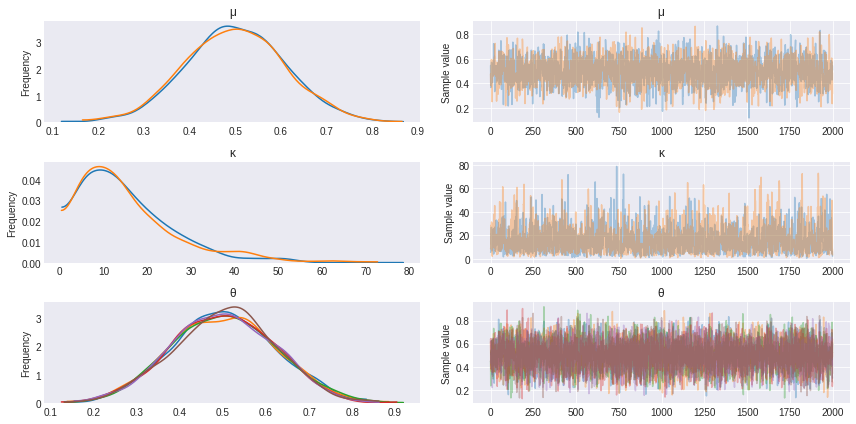

In [28]:
pm.traceplot(trace_j);

In [29]:
#pm.autocorrplot(trace_j);

In [30]:
pm.summary(trace_j).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,0.50,0.11,0.00,0.30,0.72,2493.39,1.0
κ,15.85,11.31,0.25,0.78,39.35,1922.84,1.0
θ__0,0.50,0.12,0.00,0.28,0.74,2906.60,1.0
θ__1,0.50,0.12,0.00,0.27,0.74,2768.72,1.0
θ__2,0.50,0.12,0.00,0.27,0.73,2901.50,1.0


Podemos observar que el valor de $\kappa$ del _a posteriori_ es mayor que del _a priori_. Esto es razonable ya que los experimentos con las 3 han resultado idénticos indicando que la matriz tiene un efecto importante sobre el resultado de $\theta$ para cada moneda.

¿Qué distribución hubiéramos obtenido para $\kappa$ si las monedan hubieran mostrado distintos resultados?
Probemos que hubiera pasado si:

z = [1, 5, 9]

### Mirando el _a posteriori_ desde varios lados

El _a posteriori_ contiene toda la información que resulta de un análisis Bayesiano. Por lo que puede ser muy informativo analizarlo desde varios lados. Además de los gráficos que provee PyMC3, podemos analizar el _a posteriori_ usando nuestras propias gráficas, por ejemplo podemos estar interesados en observar como se correlacionan distintos parámetros.

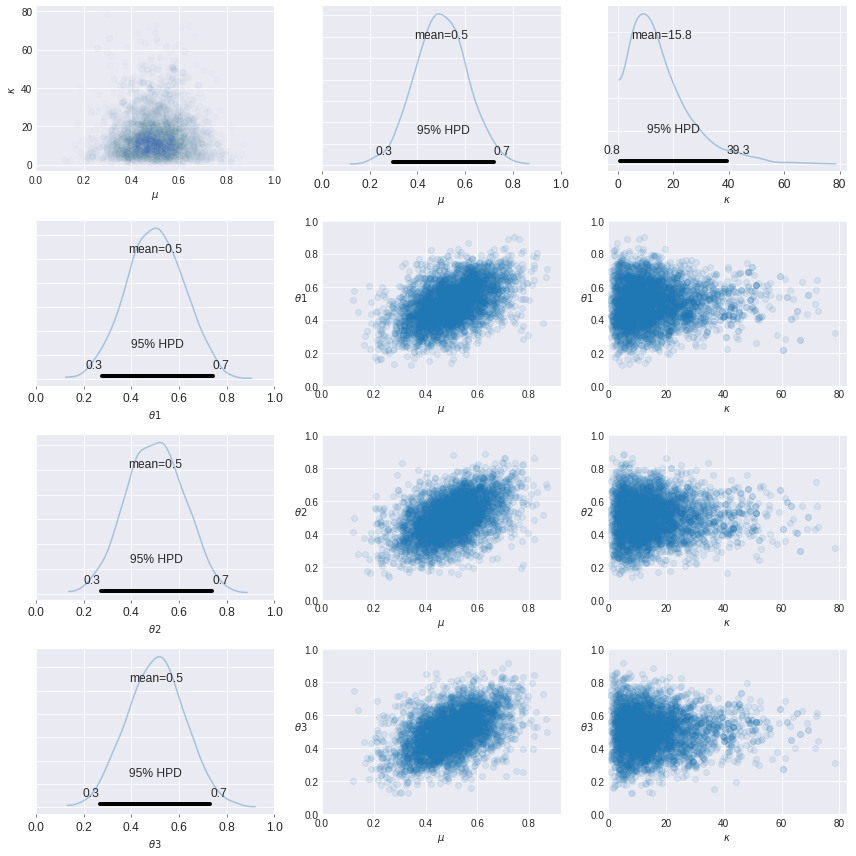

In [31]:
# Creamos arreglos tomando muestras del posterior
theta1_pos = trace_j['θ'][:,0]
theta2_pos = trace_j['θ'][:,1]
theta3_pos = trace_j['θ'][:,2]
mu_pos = trace_j['μ']
kappa_pos = trace_j['κ']

_, ax = plt.subplots(4, 3, figsize=(12, 12))

# Gráficos de dispersión de los hiper-parámetros
ax[0, 0].scatter(mu_pos, kappa_pos, marker='o', alpha=0.01)
ax[0, 0].set_xlim(0,1)
ax[0, 0].set_xlabel(r'$\mu$')
ax[0, 0].set_ylabel(r'$\kappa$')

pm.plot_posterior(mu_pos, ax=ax[0, 1], kde_plot=True, round_to=1)
ax[0, 1].set_xlabel(r'$\mu$')
ax[0, 1].set_xlim(0,1)

pm.plot_posterior(kappa_pos, ax=ax[0, 2], kde_plot=True, round_to=1)
ax[0, 2].set_xlabel(r'$\kappa$')
count = 1
for i, j in (theta1_pos, 'theta1'), (theta2_pos, 'theta2'), (theta3_pos, 'theta3'):
    pm.plot_posterior(i, ax=ax[count, 0], kde_plot=True, round_to=1)
    ax[count, 0].set_xlabel('$\{}$'.format(j))
    ax[count, 0].set_xlim(0,1)
    countb = 1
    for k, l in (mu_pos, 'mu'), (kappa_pos, 'kappa'):
        ax[count, countb].scatter(k, i, marker='o', alpha=0.1)
        ax[count, countb].set_xlabel('$\{}$'.format(l))
        ax[count, countb].set_ylabel('$\{}$'.format(j), rotation=0)
        ax[count, countb].set_xlim(0)
        ax[count, countb].set_ylim(0,1)
        countb += 1
    count += 1

plt.tight_layout();

### Contracción (_shrinking_)

Probemos ahora con otros ejemplos (puede ser conveniente guardar las figuras obtenidas con distintos nombres).

* z = [1,1,1] 
* z = [9,9,9] 
* z = [9,1,9]

¿Cuáles son los valores de $\theta$ obtenidos en cada caso? Es lo mismo el valor estimado de $\theta$ para una moneda cuando cae 1 de 10 veces caras (y las otras dos también), que cuando una moneda cae 1 de 10 veces caras y las otras dos caen 9 de 10 veces cara?

Como podrán ver si hacen el ejercicio, el valor estimado $\theta$ no es el mismo! ¿Por qué sucede esto?

Porque el modelo especifica que las monedas NO son independientes. El modelo asume que las 3 monedas provienen de una misma matriz, por lo tanto la estimación de $\theta$ para una moneda es afectada por las otras y al mismo tiempo afecta a las otras. Este fenómeno se llama contracción, la razón del nombre es que las estimaciones individuales tienden a contraerse alrededor del valor promedio de las 3 estimaciones (en nuestro modelo $\mu$) esto se hace mas evidente para los valores _aberrantes_. Si todas las monedas menos una indican un valor de $\theta$ más o menos similar la que posee el valor distinto tendrá un $\theta$ mucho más cercano al valor de las demás que si la hubiéramos estimado de forma individual.

Esto quizá pueda parecerles problemático, pero no es más que un reflejo de lo que asumimos al crear el modelo. La matriz con la que fueron echas las monedas influencia el sesgo de las mismas. Entonces, la estimación de cada elemento del vector $\theta$ debe influenciar y ser influenciado por las estimaciones de los demás elementos de $\theta$. Esto es una forma de regularización que los métodos frecuentistas deben introducir _ad-hoc_, pero que sin embargo ya viene incluido en un análisis Bayesiano.

Entonces el modelo jerárquico Bayesiano que hemos construido nos dice no solo los valores de $\theta$, si no lo valores de $\mu$ (el sesgo promedio) introducido por la matriz y los valores de $\kappa$, cuan fuerte es el efecto de la matriz sobre los sesgos individuales de $\theta$